# 🌴 Panama Papers - Offshore Financial Network Analysis

## Demo Notebook

This notebook demonstrates the capabilities of our Panama Papers analysis system built with:
- **Neo4j 5.x** - Graph Database
- **FastAPI** - REST API
- **Docker** - Container Orchestration

### Dataset Overview
- **Source**: ICIJ Offshore Leaks Database (https://offshoreleaks.icij.org/)
- **Entities**: 814,344 offshore companies, trusts, foundations
- **Officers**: 771,315 directors, shareholders, beneficiaries
- **Addresses**: 402,246 registered addresses
- **Intermediaries**: 25,629 law firms, banks, agents
- **Relationships**: 2,798,188 connections

## 1. Setup & Configuration

In [25]:
# Install required packages (run once)
# !pip install neo4j pandas requests matplotlib

In [26]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
import json

# Configuration
API_BASE_URL = "http://localhost:8000"
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "password"

# Neo4j Driver
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def run_query(query, params=None):
    """Execute a Cypher query and return results as a list of dicts."""
    with driver.session() as session:
        result = session.run(query, params or {})
        return [record.data() for record in result]

print("✅ Connected to Neo4j and API")

✅ Connected to Neo4j and API


## 2. Database Overview

📊 Node Counts:


,node_type,count
0,Entity,814344
1,Officer,771315
2,Address,402246
3,Intermediary,25629


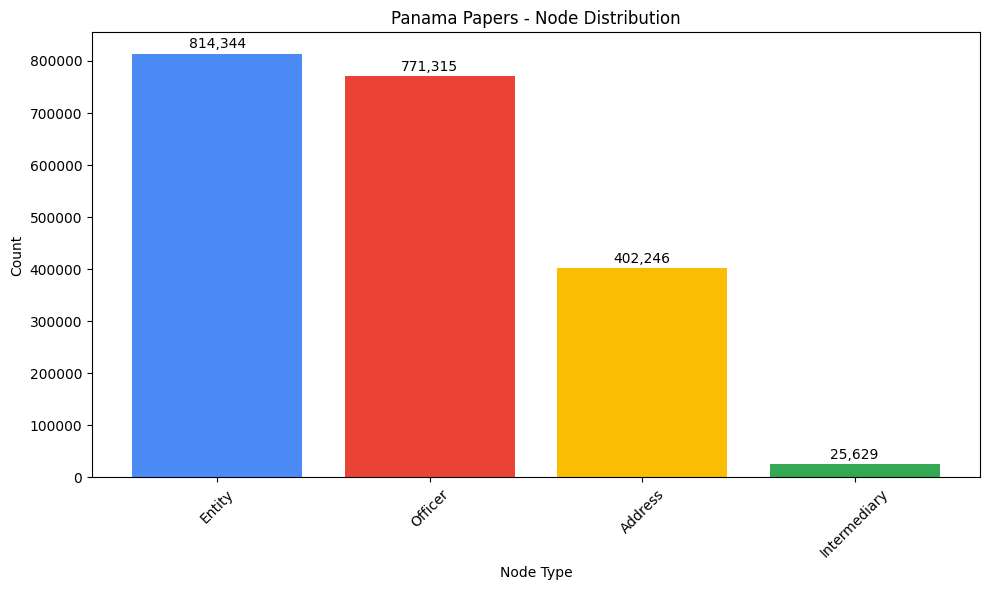

In [27]:
# Count all node types
node_counts = run_query("""
    MATCH (n)
    RETURN labels(n)[0] AS node_type, count(n) AS count
    ORDER BY count DESC
""")

df_nodes = pd.DataFrame(node_counts)
print("📊 Node Counts:")
display(df_nodes)

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(df_nodes['node_type'], df_nodes['count'], color=['#4C8BF5', '#EA4335', '#FBBC04', '#34A853'])
plt.title('Panama Papers - Node Distribution')
plt.xlabel('Node Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
for i, v in enumerate(df_nodes['count']):
    plt.text(i, v + 10000, f'{v:,}', ha='center')
plt.tight_layout()
plt.show()

🔗 Relationship Counts:


,relationship_type,count
0,OFFICER_OF,1711446
1,INTERMEDIARY_OF,590096
2,REGISTERED_ADDRESS,336951
3,SAME_NAME_AS,97774
4,SIMILAR,46398
5,SAME_COMPANY_AS,15523


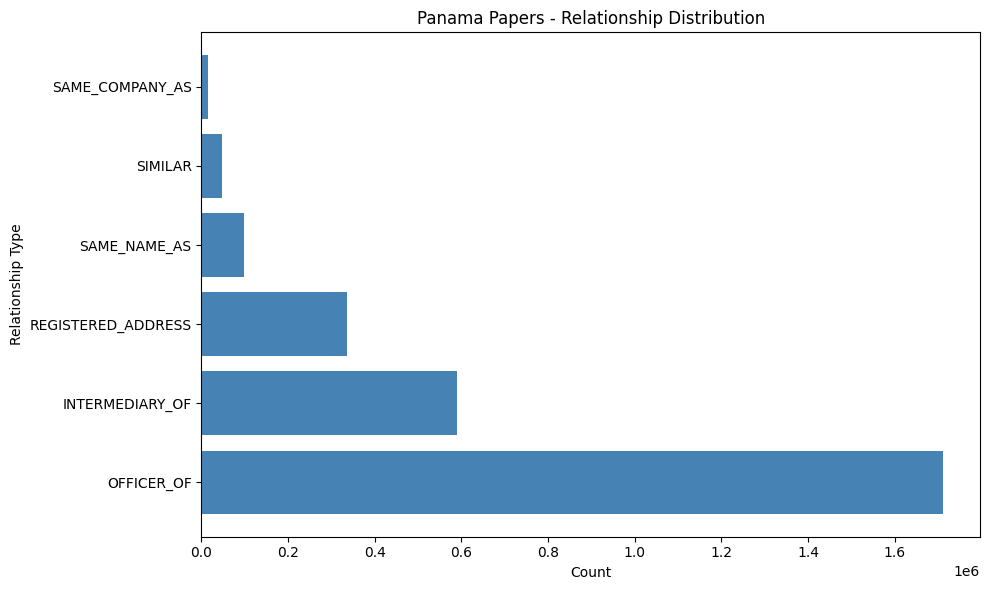

In [28]:
# Count relationship types
rel_counts = run_query("""
    MATCH ()-[r]->()
    RETURN type(r) AS relationship_type, count(r) AS count
    ORDER BY count DESC
""")

df_rels = pd.DataFrame(rel_counts)
print("🔗 Relationship Counts:")
display(df_rels)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(df_rels['relationship_type'], df_rels['count'], color='steelblue')
plt.title('Panama Papers - Relationship Distribution')
plt.xlabel('Count')
plt.ylabel('Relationship Type')
plt.tight_layout()
plt.show()

## 3. API Demonstration

In [29]:
# Health Check
response = requests.get(f"{API_BASE_URL}/health")
print("🏥 Health Check:")
print(json.dumps(response.json(), indent=2))

🏥 Health Check:
{
  "status": "healthy",
  "timestamp": "2025-12-19T11:04:10.912777",
  "version": "1.0.0",
  "environment": "development",
  "checks": {
    "api": true,
    "neo4j": true
  },
  "neo4j": {
    "connected": true,
    "version": "5.26.18",
    "edition": "community",
    "database": "neo4j",
    "latency_ms": 4.33,
    "gds_available": false,
    "gds_version": null
  },
  "uptime_seconds": 7158.01
}


In [30]:
# Search for Mossack Fonseca (the law firm at the center of Panama Papers)
response = requests.get(f"{API_BASE_URL}/entities/search", params={"q": "Mossack Fonseca"})
results = response.json()

print(f"🔍 Search Results for 'Mossack Fonseca': {results['total_results']} entities found")
print("\nTop 5 Results:")
for r in results['results'][:5]:
    print(f"  - {r['name']} ({r['jurisdiction_code']}) - {r['status']}")

🔍 Search Results for 'Mossack Fonseca': 101 entities found

Top 5 Results:
  - MFP - MOSSACK FONSECA & PARTNERS CORP. (SAM) - Defaulted
  - MFP-MOSSACK FONSECA & PARTNERS CORP. (NIUE) - Inactivated
  - MOSSACK FONSECA & ASSOCIATES, S.A. (PMA) - Active
  - MOSSACK FONSECA & ASSOCIATES, S.A.. (PMA) - Active
  - MOSSACK FONSECA & C. (U.K.) LIMITED (BAH) - None


In [31]:
# Search for entities by jurisdiction
response = requests.get(f"{API_BASE_URL}/entities/by-jurisdiction/BVI", params={"limit": 10})
bvi_entities = response.json()

print("🏝️ British Virgin Islands Entities (Top 10):")
for e in bvi_entities[:10]:
    print(f"  - {e['name']} ({e['status']})")

🏝️ British Virgin Islands Entities (Top 10):
  - "Centre D' Affaires Internationales" (Asia) Ltd (Active)
  - "Centre D'Affaires Internationales" (Asia) Ltd (Active)
  - "D" Oil Corp. (Defaulted)
  - "IRA" OVERSEAS LIMITED (Defaulted)
  - "LA PADOVANA" LTD. (Defaulted)
  - &gt;&gt;KENE INC. (Dissolved)
  - (A.O.I.) ALPINE OIL INC. (Defaulted)
  - (FWWI) Formations Worldwide Inc. (Active)
  - (HONG KONG)TREASURES NOT LIMITED (Active)
  - (IAID) INVESTMENT AND ASSOCIATION FOR INTERNATIONAL AND DEVE (Defaulted)


## 4. Advanced Cypher Queries

### 4.1 Top Jurisdictions by Entity Count

🌍 Top 15 Jurisdictions by Entity Count:


,jurisdiction,entity_count
0,BAH,209634
1,BVI,167841
2,MLT,83929
3,KNA,70516
4,XXX,53200
5,AW,49050
6,PMA,48373
7,BRB,40839
8,SEY,15580
9,SAM,15013


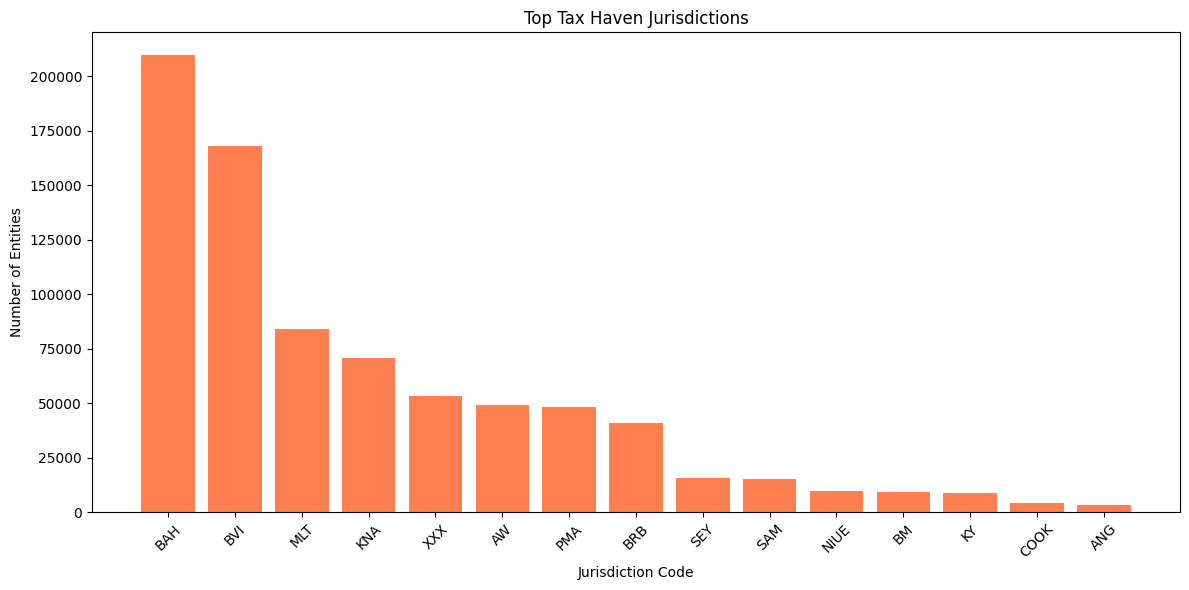

In [32]:
# Top jurisdictions (tax havens)
jurisdictions = run_query("""
    MATCH (e:Entity)
    WHERE e.jurisdiction_code IS NOT NULL
    RETURN e.jurisdiction_code AS jurisdiction, count(e) AS entity_count
    ORDER BY entity_count DESC
    LIMIT 15
""")

df_jurisdictions = pd.DataFrame(jurisdictions)
print("🌍 Top 15 Jurisdictions by Entity Count:")
display(df_jurisdictions)

# Visualize
plt.figure(figsize=(12, 6))
plt.bar(df_jurisdictions['jurisdiction'], df_jurisdictions['entity_count'], color='coral')
plt.title('Top Tax Haven Jurisdictions')
plt.xlabel('Jurisdiction Code')
plt.ylabel('Number of Entities')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4.2 Most Connected Officers (Hub Analysis)

In [33]:
# Officers connected to the most entities (potential nominees or key figures)
top_officers = run_query("""
    MATCH (o:Officer)-[:OFFICER_OF]->(e:Entity)
    WITH o, count(DISTINCT e) AS entity_count
    ORDER BY entity_count DESC
    LIMIT 20
    RETURN o.name AS officer_name, entity_count
""")

df_officers = pd.DataFrame(top_officers)
print("👔 Top 20 Officers by Number of Connected Entities:")
print("(These are likely nominee directors or key intermediary figures)")
display(df_officers)

👔 Top 20 Officers by Number of Connected Entities:
(These are likely nominee directors or key intermediary figures)


,officer_name,entity_count
0,Portcullis TrustNet (BVI) Limited,36245
1,Portcullis TrustNet (Samoa) Limited,4227
2,MOSSFON SUBSCRIBERS LTD.,3882
3,Reid Services Limited - Cayman,2703
4,Portcullis TrustNet (Samoa) Limited,2271
5,Standard Directors Ltd.,1993
6,Execorp Limited,1872
7,Equity Trust (Samoa) Limited,1675
8,PRICEWATERHOUSECOOPERS,1634
9,Sharecorp Limited,1631


### 4.3 Most Active Intermediaries (Law Firms, Banks)

🏛️ Top 15 Intermediaries (Law Firms, Banks, Agents):


,intermediary_name,entity_count
0,Morning Star Holdings Limited,35358
1,MOSSACK FONSECA & CO. (BAHAMAS) LIMITED,14901
2,UBS TRUSTEES (BAHAMAS) LTD.,9717
3,CREDIT SUISSE TRUST LIMITED,8299
4,TRIDENT CORPORATE SERVICES (BAH) LTD,8286
5,MMG BAHAMAS LTD.,8149
6,ORION HOUSE SERVICES (HK) LIMITED,7016
7,Internal User,6607
8,Unitrust Corporate Services Ltd.,5699
9,K.M.C. CORPORATE SERVICES LTD.,5318


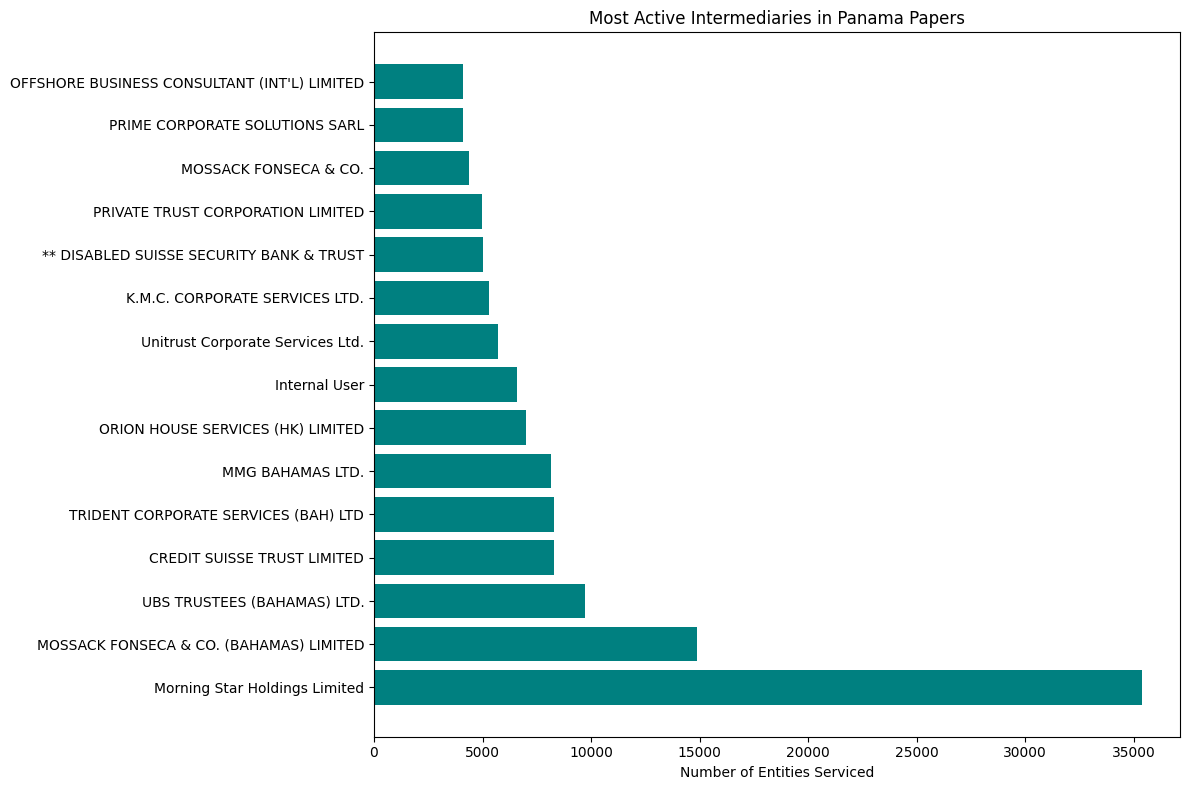

In [34]:
# Top intermediaries (law firms, agents)
top_intermediaries = run_query("""
    MATCH (i:Intermediary)-[:INTERMEDIARY_OF]->(e:Entity)
    WITH i, count(DISTINCT e) AS entity_count
    ORDER BY entity_count DESC
    LIMIT 15
    RETURN i.name AS intermediary_name, entity_count
""")

df_intermediaries = pd.DataFrame(top_intermediaries)
print("🏛️ Top 15 Intermediaries (Law Firms, Banks, Agents):")
display(df_intermediaries)

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(df_intermediaries['intermediary_name'], df_intermediaries['entity_count'], color='teal')
plt.title('Most Active Intermediaries in Panama Papers')
plt.xlabel('Number of Entities Serviced')
plt.tight_layout()
plt.show()

### 4.4 Shared Addresses (Red Flag Detection)

In [35]:
# Addresses shared by many entities (mass registration - red flag)
shared_addresses = run_query("""
    MATCH (e:Entity)-[:REGISTERED_ADDRESS]->(a:Address)
    WITH a, count(DISTINCT e) AS entity_count
    WHERE entity_count > 100
    ORDER BY entity_count DESC
    LIMIT 10
    RETURN a.address AS address, entity_count
""")

df_addresses = pd.DataFrame(shared_addresses)
print("🚩 RED FLAG: Addresses with 100+ Registered Entities:")
print("(Mass registration addresses often indicate shell company factories)")
display(df_addresses)

🚩 RED FLAG: Addresses with 100+ Registered Entities:
(Mass registration addresses often indicate shell company factories)


,address,entity_count
0,Portcullis TrustNet Chambers P.O. Box 3444 Roa...,36334
1,"3rd Floor, Yamraj Building, Market Square, P.O...",11962
2,Clifton House,8148
3,Canon's Court,6810
4,Unitrust Corporate Services Ltd. John Humphrie...,5699
5,Argyle House,5166
6,"Sealight Incorporations Limited Room 1201, Con...",3896
7,"Company Kit Limited Unit A, 6/F Shun On Comm B...",2671
8,"171 OLD BAKERY STREET, VALLETTA, MALTA",2505
9,"COMMENCE CHAMBERS, P.O. BOX 2208, ROAD TOWN, B...",2349


### 4.5 Network Depth Analysis (Ownership Layering)

🔍 Top Nominee Directors / Corporate Service Providers:
(These entities act as officers for thousands of shell companies)


,officer,entity_count,sample_entities
0,Portcullis TrustNet (BVI) Limited,36335,"[L.C. INTERNATIONAL CO., LTD., Network Pulse L..."
1,Portcullis TrustNet (Samoa) Limited,4237,"[Windsor International Management Incorp., Bri..."
2,MOSSFON SUBSCRIBERS LTD.,3882,"[BRISWAY HOLDINGS LTD., OCEAN SAILOR SHIPPING ..."
3,Reid Services Limited - Cayman,3003,"[Krinein Company, Aviation 49284 Corporation, ..."
4,Portcullis TrustNet (Samoa) Limited,2338,"[Asian Group Finance Limited, The Olympic Inve..."
5,Execorp Limited,1998,"[LOONG WAN OFFSHORE LIMITED, WINCHESTER SECURI..."
6,Standard Directors Ltd.,1993,"[Damarton Group Ltd., LEOMART PRODUCTIONS INC...."
7,Equity Trust (Samoa) Limited,1675,"[HEXAS LIMITED, EXTRAORDINARY UNION ENTERPRISE..."
8,Sharecorp Limited,1644,"[UXBRIDGE INTERNATIONAL LIMITED, Global Financ..."
9,PRICEWATERHOUSECOOPERS,1634,"[2M ENERGY SOLUTIONS LTD, EC GLOBAL LIMITED, H..."


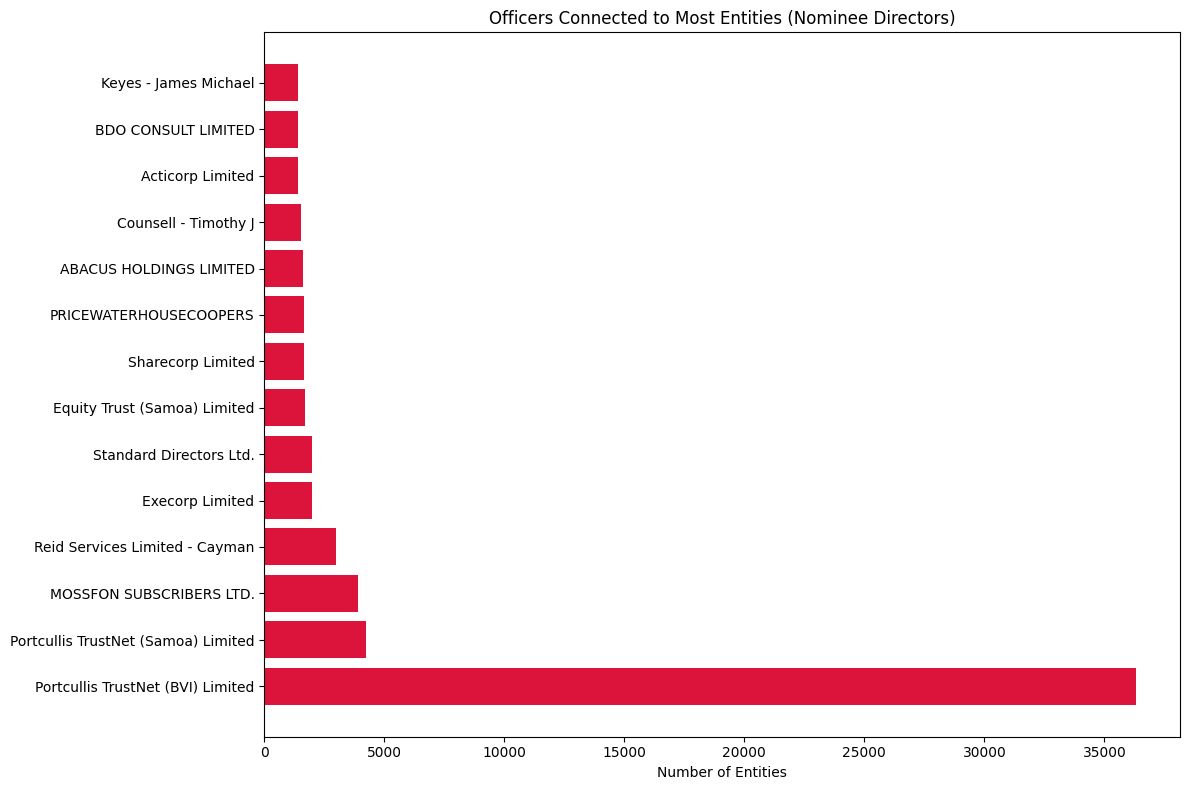

In [36]:
# Find officers/nominees connected to the most entities (hub analysis)
top_officers = run_query("""
    MATCH (o:Officer)-[:OFFICER_OF]->(e:Entity)
    WITH o, collect(e.name) AS entities, count(e) AS entity_count
    WHERE entity_count >= 50
    RETURN o.name AS officer, entity_count, entities[0..5] AS sample_entities
    ORDER BY entity_count DESC
    LIMIT 20
""")

df_officers = pd.DataFrame(top_officers)
print("🔍 Top Nominee Directors / Corporate Service Providers:")
print("(These entities act as officers for thousands of shell companies)")
display(df_officers)

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(df_officers['officer'][:15], df_officers['entity_count'][:15], color='crimson')
plt.title('Officers Connected to Most Entities (Nominee Directors)')
plt.xlabel('Number of Entities')
plt.tight_layout()
plt.show()

## 5. Query Performance Analysis (EXPLAIN/PROFILE)

In [37]:
# Profile a query to show execution plan
profile_result = run_query("""
    PROFILE
    MATCH (e:Entity {jurisdiction_code: 'BVI'})
    RETURN e.name, e.status
    LIMIT 100
""")

print("📊 Query uses index on Entity.jurisdiction_code for fast lookup")
print(f"Results returned: {len(profile_result)}")

📊 Query uses index on Entity.jurisdiction_code for fast lookup
Results returned: 100


In [38]:
# Show indexes
indexes = run_query("SHOW INDEXES")
df_indexes = pd.DataFrame(indexes)
print("📑 Database Indexes:")
display(df_indexes[['name', 'state', 'type', 'labelsOrTypes', 'properties']])

📑 Database Indexes:


,name,state,type,labelsOrTypes,properties
0,address_id_unique,ONLINE,RANGE,[Address],[address_id]
1,entity_id_unique,ONLINE,RANGE,[Entity],[entity_id]
2,index_343aff4e,ONLINE,LOOKUP,None,None
3,index_f7700477,ONLINE,LOOKUP,None,None
4,intermediary_id_unique,ONLINE,RANGE,[Intermediary],[intermediary_id]
5,officer_id_unique,ONLINE,RANGE,[Officer],[officer_id]


## 6. Graph Exploration - Specific Entity Analysis

In [39]:
# Find all connections for a specific entity (Mossack Fonseca)
mf_network = run_query("""
    MATCH (e:Entity)
    WHERE e.name CONTAINS 'MOSSACK FONSECA'
    WITH e LIMIT 1
    OPTIONAL MATCH (e)-[:REGISTERED_ADDRESS]->(a:Address)
    OPTIONAL MATCH (o:Officer)-[:OFFICER_OF]->(e)
    OPTIONAL MATCH (i:Intermediary)-[:INTERMEDIARY_OF]->(e)
    RETURN e.name AS entity, 
           e.jurisdiction_code AS jurisdiction,
           collect(DISTINCT a.address)[0..3] AS addresses,
           collect(DISTINCT o.name)[0..5] AS officers,
           collect(DISTINCT i.name)[0..3] AS intermediaries
""")

print("🕵️ Mossack Fonseca Network Analysis:")
for item in mf_network:
    print(f"\nEntity: {item['entity']}")
    print(f"Jurisdiction: {item['jurisdiction']}")
    print(f"Addresses: {item['addresses']}")
    print(f"Officers: {item['officers']}")
    print(f"Intermediaries: {item['intermediaries']}")

🕵️ Mossack Fonseca Network Analysis:

Entity: MOSSACK FONSECA & CO. (SAMOA) LIMITED
Jurisdiction: SAM
Addresses: []
Officers: ['MOSSFON SUBSCRIBERS LTD.', 'MF PRIVATE HOLDINGS LTD.']
Intermediaries: ['MOSSACK FONSECA & CO. (PTY)']


## 7. Statistical Summary

📈 Entity Status Distribution:


,status,count
0,None,456308
1,Active,116025
2,Defaulted,100090
3,Dissolved,24082
4,Dead,23095
...,...,...
82,Continuation-Out,1
83,2012-03-19 00:00:00,1
84,"active (transferred to Fidelity on 2012-07-13,...",1
85,LIQUIDATED,1


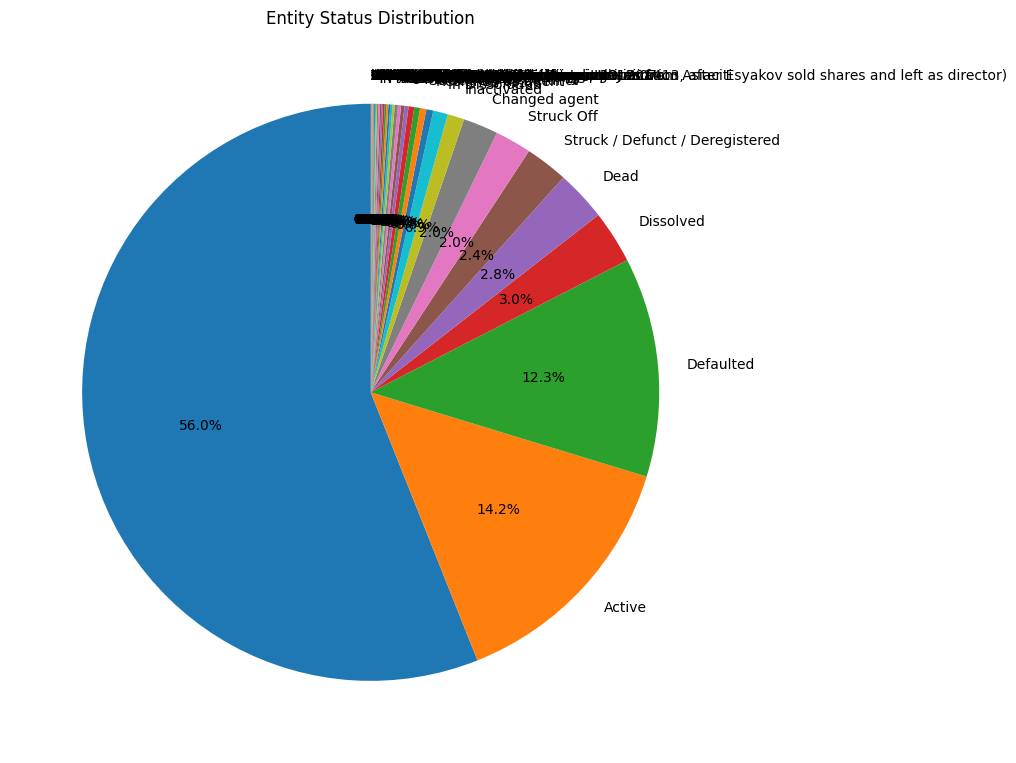

In [40]:
# Entity status distribution
status_dist = run_query("""
    MATCH (e:Entity)
    RETURN e.status AS status, count(e) AS count
    ORDER BY count DESC
""")

df_status = pd.DataFrame(status_dist)
print("📈 Entity Status Distribution:")
display(df_status)

# Pie chart
plt.figure(figsize=(10, 8))
plt.pie(df_status['count'], labels=df_status['status'], autopct='%1.1f%%', startangle=90)
plt.title('Entity Status Distribution')
plt.tight_layout()
plt.show()

## 8. Cleanup

In [41]:
# Close the Neo4j driver connection
driver.close()
print("✅ Connection closed")

✅ Connection closed


---

## Summary

This demo notebook showcased:

1. **Database Statistics** - Node and relationship counts with visualizations
2. **API Integration** - Health checks, search, and filtering via REST API
3. **Advanced Cypher Queries**:
   - Jurisdiction analysis (tax havens)
   - Hub detection (most connected officers)
   - Intermediary ranking (law firms, banks)
   - Red flag detection (shared addresses)
   - Ownership depth analysis (layering)
4. **Performance Analysis** - PROFILE queries and index verification
5. **Entity Network Exploration** - Deep dive into specific entities

### Key Findings
- **BVI (British Virgin Islands)** and **Panama** are the top jurisdictions
- Some officers are connected to **thousands** of entities (nominee directors)
- Certain addresses host **hundreds** of shell companies
- Deep ownership layering is common for hiding beneficial ownership

---
*Panama Papers Analysis Project - Built with Neo4j, FastAPI, and Docker*